# Tracking and Detection in Computer Vision Exercise 3

Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import tensorflow as tf
#import cv2
import os
import random

import props

In [5]:
%matplotlib inline
random.seed()

Check that all necessary properties are defined and reasonable

In [7]:
print(props.DATA_ROOT)
print(props.DATA_PREP)
print(props.WEIGHTS)

C:/Users/thomala/Documents/TDCV-misc/ex3/dataset/
C:/Users/thomala/Documents/TDCV-misc/ex3/preprocessing/
C:/Users/thomala/Documents/TDCV-misc/ex3/weights/model.ckpt


# Task 1 Data Preparation

## Utility functions to load the data

In [8]:
def load_and_normalize_image(img_path):
    img = misc.imread(img_path)
    img_norm = (img - np.mean(img,axis=(0,1)))/np.std(img,axis=(0,1))
    return img_norm

In [9]:
def read_folder(folder_path, class_label, mask=[], direct=False):
    # gets the images in folder folder_path that are also in mask,
    # or if direct=False the images that are not in mask
    directory = os.fsencode(folder_path)
    image_files = []
    quaternions = []
    real_mask = []
    parent_folder = folder_path.split('/')[-3] # here we assume the files are stored in "xxx/abc/xxx/abc123.png
    quaternions = [[float(s) for s in line.split()]\
                     for line in open(folder_path + 'poses.txt').readlines()[1::2]]
    if direct:
        real_mask = mask
    else:
        real_mask = [i for i in range(len(quaternions)) if i not in mask]
    classes = [class_label]*len(real_mask)
    
    for n in real_mask:
        filename = parent_folder + str(n) + ".png"
        image_files.append(load_and_normalize_image(folder_path + filename))
        
    return image_files, [quaternions[i] for i in real_mask], classes

### Testing the above functions

In [10]:
for i in range(1): # just to avoid creating useless global variables
    i1, q1, l1 = read_folder(props.DATA_ROOT + 'coarse/ape/', 0)
    i2, q2, l2 = read_folder(props.DATA_ROOT + 'coarse/ape/', 0, [2,3,5,7,9])
    i3, q3, l3 = read_folder(props.DATA_ROOT + 'coarse/ape/', 0, [2,3,5,7,9], True)
    print (len(i1))
    print (len(i2))
    print (len(i3))
    print (len(q1))
    print (len(q2))
    print (len(q3))
    print (len(l1))
    print (len(l2))
    print (len(l3))
    print (q2[0])
    print (np.shape(i2[0]))
    #print(i2[0][::8,::8,:])

c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


267
262
5
267
262
5
267
262
5
[-0.21679691686430014, -0.5855909685700639, 0.7631570083471646, -0.16635412522060855]
(64, 64, 3)


## Utility functions to visualize images

In [11]:
def to_visible(image):
    # puts image back in [0;1], so that we can visualize it
    mn = np.min(image)
    wd = np.max(image) - mn
    
    return (image - mn)/wd

def concatenate(images, indices):
    if len(np.shape(indices)) == 1:
        # concatenate samples from images with indices in 1D indices into one line
        res = to_visible(images[indices[0]])
        for index in indices[1:]:
            res = np.concatenate((res, to_visible(images[index])), axis=1)
        return res
    else:
        # reduce one dimension
        res = concatenate(images, indices[0])
        for index_array in indices[1:]:
            res = np.concatenate((res, concatenate(images, index_array)), axis=0)
        return res

def visualize(images, indices, save_path=""):
    fig = plt.figure()
    plt.imshow(concatenate(images, indices))
    plt.axis('off')
    if len(save_path) > 0:
        plt.savefig(save_path, pad_inches=0) # TODO there is still some white remaining in the result
    plt.show()

## Load the images and quaternions into datasets

_You need to read the images together with the poses (stored in quaternions) and construct 3 datasets:
the training set $S_{train}$ (train subset of the real folder and fine folder), test set $S_{test}$ (test
subset of the real folder) and database set $S_{db}$ ("coarse" folder)_

In [12]:
class Dataset:
    
    def __init__(self):
        self.images = [] # pictures
        self.quats = [] # poses of each picture
        self.classes = [] # classes of each picture
    """ >> TODO make these work
    def add_image(img, quat, self):
        self.images.append(img)
        self.quats.append(quat)
    
    def get_image(i, self):
        img = self.images[i]
        quat = self.quats[i]
        return img, quat
    
    def add_data(imgs, quats, self):
        for img, quat in imgs, quats:
            self.add_image(img, quat)
    """

In [13]:

CLASSES = ['ape', 'benchvise', 'cam', 'cat', 'duck']

print("[WARNING] Remove real/duck/real1178-1252, we don't have their poses!")

S_TRAIN = Dataset()

S_TEST = Dataset()

S_DB = Dataset()

TRAIN_MASK = [int(s) for s in open(props.DATA_ROOT + 'real/training_split.txt')\
               .readlines()[0].split(',')]


[WARNING] Remove real/duck/real1178-1252, we don't have their poses!


In [14]:
for class_index in range(len(CLASSES)):
    class_name = CLASSES[class_index]
    print(class_name)
    img_db, quat_db, c_db = read_folder(props.DATA_ROOT + 'coarse/' + class_name + '/', class_index)
    img_fn, quat_fn, c_fn = read_folder(props.DATA_ROOT + 'fine/' + class_name + '/', class_index)
    img_tn, quat_tn, c_tn = read_folder(props.DATA_ROOT + 'real/' + class_name + '/', class_index,
                                 TRAIN_MASK, True)
    img_ts, quat_ts, c_ts = read_folder(props.DATA_ROOT + 'real/' + class_name + '/', class_index,
                                 TRAIN_MASK, False)
    
    
    for img in img_db:
        S_DB.images.append(img)
    for quat in quat_db:
        S_DB.quats.append(quat)
    for c in c_db:
        S_DB.classes.append(c)
    for img in img_fn:
        S_TRAIN.images.append(img)
    for quat in quat_fn:
        S_TRAIN.quats.append(quat)
    for c in c_fn:
        S_TRAIN.classes.append(c)
    for img in img_tn:
        S_TRAIN.images.append(img)
    for quat in quat_tn:
        S_TRAIN.quats.append(quat)
    for c in c_tn:
        S_TRAIN.classes.append(c)
    for img in img_ts:
        S_TEST.images.append(img)
    for quat in quat_ts:
        S_TEST.quats.append(quat)
    for c in c_ts:
        S_TEST.classes.append(c)
    
    

ape


c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


benchvise
cam
cat
duck


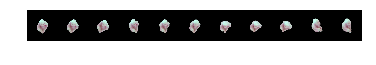

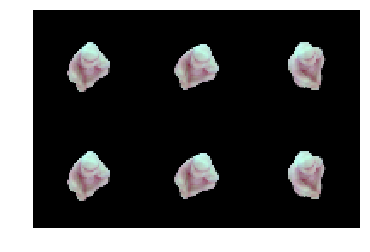

In [15]:
visualize(S_DB.images, [0, 1,2,3, 4, 5, 6, 7, 8, 9, 10])
visualize(S_DB.images, [[1,2,3],[1,2,3]], props.DATA_PREP + "test.png")

### Check datasets

Sizes should be 2-by-2 equal, images contain $64 \times 64 \times 3$ arrays, quaternions contain 4 coordinates, classes just one, and sizes be 1335 for DB, 7410 for TRAIN and 3535 for TEST

In [16]:
print (np.shape(S_DB.images))
print (np.shape(S_DB.quats))
print (np.shape(S_DB.classes))
print (np.shape(S_TRAIN.images))
print (np.shape(S_TRAIN.quats))
print (np.shape(S_TRAIN.classes))
print (np.shape(S_TEST.images))
print (np.shape(S_TEST.quats))
print (np.shape(S_TEST.classes))

(1335, 64, 64, 3)
(1335, 4)
(1335,)
(7410, 64, 64, 3)
(7410, 4)
(7410,)
(3535, 64, 64, 3)
(3535, 4)
(3535,)


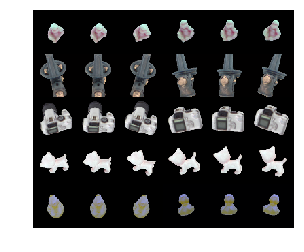

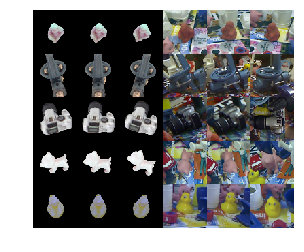

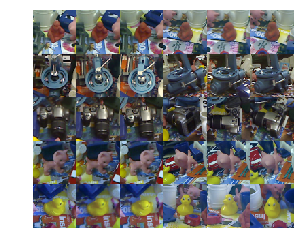

In [17]:
for h in range(1):
    n = len(S_DB.images) // 5
    visualize(S_DB.images, [[i*n, i*n+1, i*n+2, i*n+n-3, i*n+n-2, i*n+n-1] for i in range(5)])
    n = len(S_TRAIN.images) // 5
    visualize(S_TRAIN.images, [[i*n, i*n+1, i*n+2, i*n+n-3, i*n+n-2, i*n+n-1] for i in range(5)])
    n = len(S_TEST.images) // 5
    visualize(S_TEST.images, [[i*n, i*n+1, i*n+2, i*n+n-3, i*n+n-2, i*n+n-1] for i in range(5)])

## Batch generator

_The batch generator should be able to construct batches of triplets that are
later fed to the network. Each triplet consists of 3 samples: anchor, puller, and
pusher. Anchor is chosen randomly from the training set $S_{train}$. Puller is the most similar
(quaternion-wise) to anchor sample of the same object taken from the db set $S_{db}$. Finally, there are 2 types of pushers: it can either be the same object but a different
from puller pose or a randomly chosen different object. Pushers are also drawn from $S_{db}$_

### Create a random batch element following these requirements

Since quaterions in our case are of unit norm, their dot product is always in [0;1] in absolute value. Since arccos is strictly non-decreasing over [0;1], minimizing the quaternion angular metric $\theta(q_1, q_2) = 2 arccos(|q_1.q_2|)$ is strictly equivalent to maximizing their dot product, which is what we do to find the puller, for obvious speed reasons

In [18]:
def find_puller(quat, c):
    best_puller = 0
    best_result = 0
    # only look for a puller of the same class!
    for index in range(len(S_DB.quats) // 5):
        current_result = abs(np.dot(quat, S_DB.quats[index + c*len(S_DB.quats) // 5]))
        if current_result > best_result:
            best_puller = index
            best_result = current_result
    return best_puller + c*len(S_DB.quats) // 5

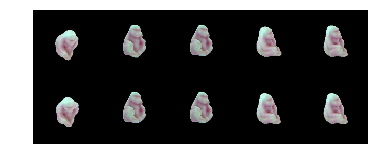

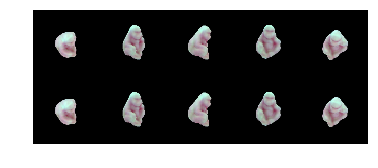

In [19]:
for a in range(1):
    images = []
    for i in range(10):
        k = random.randrange(0,300)
        images.append(S_TRAIN.images[k])
        p = find_puller(S_TRAIN.quats[k], S_TRAIN.classes[k])
        images.append(S_DB.images[p])
    visualize(images, [[2*k for k in range(5)], [2*k+1 for k in range(5)]])
    
    images = []
    for i in range(5):
        k = random.randrange(0,300)
        images.append(S_DB.images[k])
        p = find_puller(S_DB.quats[k], S_DB.classes[k])
        images.append(S_DB.images[p])
    visualize(images, [[2*k for k in range(5)], [2*k+1 for k in range(5)]])

In [20]:
def find_pusher(index, change_pose=0.5):
    nb_poses_per_object = len(S_DB.quats) // 5
    if (random.random() > change_pose):
        # then find another image with the same pose:
        # since all objects have the poses in the same order, this implies
        # looking for (index + R * N_DB / 5) % N_DB, where R is randomly
        # chosen in [1;4]
        R = random.randrange(1,5)
        return (index + R * nb_poses_per_object) % len(S_DB.quats)
    else:
        # then find another pose for the same image:
        # looking for a random number in index's interval [A,A+1]*N_DB/5
        # that isn't index, so basically (index + R) % N_DB/5 + A*N_DB/5
        # where R is randomly drawn in [1;N_DB/5]
        R = random.randrange(1,nb_poses_per_object)
        A = index // nb_poses_per_object
        return (index + R) % nb_poses_per_object + A * nb_poses_per_object

In [21]:
print("Number of poses per object:\t"+str(len(S_DB.quats) // 5))
print("Same pose, all objects are:", end='\t', flush=True)
for i in range(5):
    print(i * (len(S_DB.quats) // 5) + 325 % (len(S_DB.quats) // 5), end='\t', flush=True)
print("\nSame object, different poses are in:", end='\t', flush=True)
for i in range(1):
    N = len(S_DB.quats) // 5
    print(str((325 // N)*N) + "\t" + str((1 + 325 // N)*(N)) + "\nPusher examples:", end='\t', flush=True)
for i in range(100):
    print(find_pusher(325), end='\t', flush=True)

Number of poses per object:	267
Same pose, all objects are:	58	325	592	859	1126	
Same object, different poses are in:	267	534
Pusher examples:	859	58	859	58	859	859	859	859	435	360	592	310	1126	859	859	592	1126	58	292	1126	58	859	490	284	58	592	859	859	859	58	339	371	58	859	592	515	859	1126	1126	592	281	316	859	58	859	492	465	859	502	859	859	466	444	332	353	592	525	592	439	483	58	529	1126	1126	1126	447	382	302	328	467	394	434	408	299	58	58	58	592	291	280	434	58	447	1126	859	281	859	410	592	288	1126	58	489	1126	592	592	859	1126	1126	402	

In [22]:
def find_batch(change_pose=0.5):
    anchor = random.randrange(0, len(S_TRAIN.quats))
    puller = find_puller(S_TRAIN.quats[anchor], S_TRAIN.classes[anchor])
    pusher = find_pusher(puller, change_pose)
    return anchor, puller, pusher

In [23]:
for i in range(20):
    print(find_batch(), end="   ", flush=True)

(2035, 424, 1225)   (1650, 321, 588)   (951, 255, 1323)   (2269, 490, 303)   (4760, 896, 827)   (5354, 1049, 806)   (6539, 1238, 1209)   (4566, 843, 42)   (3690, 739, 738)   (3586, 715, 676)   (799, 227, 23)   (4542, 837, 957)   (6514, 1237, 169)   (428, 116, 110)   (1670, 332, 295)   (1780, 355, 1156)   (3047, 544, 277)   (857, 231, 255)   (2586, 510, 410)   (1874, 377, 110)   

## Generate the batch proper

In [24]:
def generate_batch(batch_size, change_pose=0.5):
    return [find_batch(change_pose) for i in range(batch_size)]

In [25]:
print(generate_batch(5))

[(1580, 305, 479), (6441, 1215, 681), (3412, 661, 1195), (1095, 209, 743), (2628, 300, 417)]


## Visualize a batch

In [26]:
def visualize_batch(batch, save_path=""):
    print(batch)
    batch_images = []
    for anchor, puller, pusher in batch:
        batch_images.append(S_TRAIN.images[anchor])
        batch_images.append(S_DB.images[puller])
        batch_images.append(S_DB.images[pusher])
    indices = [[i*3+j for i in range(len(batch))] for j in range(3)]
    visualize(batch_images, indices, save_path)

[(5473, 946, 994), (2676, 486, 400), (4832, 911, 831), (5320, 1042, 901), (691, 196, 730)]


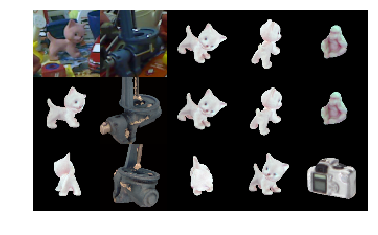

In [27]:
visualize_batch(generate_batch(5), props.DATA_PREP + "batch.png")

.  


# Task 2 Convolutional Neural Network and Loss Function

## Loss function

We define the loss function. $L=L_{triplets}+L_{pairs}$, where $L_{triplets}=\Sigma \max (0, 1-\frac{||f(x_a)-f(x_-)||^2_2}{||f(x_a)-f(x_+)||^2_2+m})$ and $L_{pairs}=\Sigma ||f(x_a)-f(x_+)||^2_2$

### _NUMPY version_

In [25]:
def loss_complete(feats): 
    #feats should be shape (batch_size * 16)
    
    batch_size=feats.shape[1]
    
    #default m
    m = 0.01
    
    #||f(x_a)-f(x+)|| and ||f(x_a)-f(x-)||
    diff_pos = feats[0: batch_size: 3] - feats[1: batch_size: 3]
    diff_neg = feats[0: batch_size: 3] - feats[2: batch_size: 3]
    
    print(diff_pos.shape)
    
    #||f(x_a)-f(x+)||^2 and ||f(x_a)-f(x-)||^2
    square_pos = np.square(diff_pos)
    square_neg = np.square(diff_neg)
    
    print(square_pos.shape)
    
    L_pairs = np.sum(square_pos)
      
    norm_2_pos=np.sum(square_pos, axis=1)
    norm_2_neg=np.sum(square_neg, axis=1)
    
    print(norm_2_pos.shape)

    L_triplets = np.sum(np.maximum(0, np.subtract(1, np.divide(norm_2_neg, np.add(norm_2_pos, m)))))
    
    L = L_triplets + L_pairs
    
    return L

Test with a small batch of 2 triplets. (So totally 3 x 16 x 2 = 96 values)

In [27]:
a=np.array([1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6])
test=[]
for i in range(6):
    test.append(a)
test=np.array(test)
print(test.shape)
print(loss_complete(test))

(6, 16)
(2, 16)
(2, 16)
(2,)
2.0


### _TENSORFLOW version_
Only this version can be our custom loss function used in tensorflow. The numpy version can't!

In [28]:
sess = tf.InteractiveSession()

In [29]:
def tf_loss_complete(feats): 
    #feats should be shape (batch_size * 16)
    
    batch_size=tf.shape(feats)[1]
    #print(batch_size.eval())
    
    #default m
    m = 0.01
    
    #||f(x_a)-f(x+)|| and ||f(x_a)-f(x-)||
    diff_pos = tf.subtract(feats[0: batch_size: 3], feats[1: batch_size: 3])
    diff_neg = tf.subtract(feats[0: batch_size: 3], feats[2: batch_size: 3])
    
    #print(diff_pos.eval().shape)
    
    #||f(x_a)-f(x+)||^2 and ||f(x_a)-f(x-)||^2
    square_pos = tf.square(diff_pos)
    square_neg = tf.square(diff_neg)
    
    #print(square_pos.eval().shape)
    
    L_pairs = tf.reduce_sum(square_pos)
      
    norm_2_pos=tf.reduce_sum(square_pos, axis=1)
    norm_2_neg=tf.reduce_sum(square_neg, axis=1)
    
    #print(norm_2_pos.eval().shape)

    L_triplets = tf.reduce_sum(tf.maximum(0.0, tf.subtract(1.0, tf.divide(norm_2_neg, tf.add(norm_2_pos, m)))))
    
    L = tf.add(L_triplets, L_pairs)
    
    return L

In [30]:
a=np.array([1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6])
test=[]
for i in range(6):
    test.append(a)
test=tf.convert_to_tensor(np.array(test), dtype=tf.float32)
print(test.shape)
print(tf_loss_complete(test).eval())

(6, 16)
2.0


## Set the network up

_The network architecture is fairly simple and closely follows that one of the famous LeNet. It consists of 2 convolutional layers, each followed by ReLu activation functions and a 2x2 max pooling layer, and 2 fully connected layers. The output descriptor size set to be 16 for all the experiments._

In [68]:
# NO!NO!NO!!!! weight_path='model/model.ckpt'

In [34]:
SESS = tf.InteractiveSession()

In [35]:
# Input Layer
#input_layer = tf.reshape(features, [-1, 64, 64, 3])
INPUT_LAYER = tf.placeholder("float32", [None, 64,64,3])
#input_layer1 = tf.reshape(input_layer, [-1, 64, 64, 3])

# Convolutional Layer #1
CONV_1 = tf.layers.conv2d(
    inputs=INPUT_LAYER,
    filters=16,
    kernel_size=[8, 8],
    padding="valid",
    activation=tf.nn.relu)

# Pooling Layer #1
POOL_1 = tf.layers.max_pooling2d(inputs=CONV_1, pool_size=[2, 2], strides=2)
   
# Convolutional Layer #2 
CONV_2 = tf.layers.conv2d(
    inputs=POOL_1,
    filters=7,
    kernel_size=[5, 5],
    padding="valid",
    activation=tf.nn.relu)
    
# Pooling Layer #2
POOL_2 = tf.layers.max_pooling2d(inputs=CONV_2, pool_size=[2, 2], strides=2)

# Flattened Layer
POOL_2_FLAT = tf.reshape(POOL_2, [-1, 12 * 12 * 7])

# First FC layer
FC_1 = tf.layers.dense(inputs=POOL_2_FLAT, units=256, activation=tf.nn.relu)

# Logits Layer
OUTPUT_LAYER = tf.layers.dense(inputs=FC_1, units = 16)

In [36]:
# Compute Loss (for both TRAIN and EVAL modes)
LOSS = tf_loss_complete(OUTPUT_LAYER)

TRAIN_OPTIMIZER = tf.train.AdamOptimizer(1e-4).minimize(LOSS)

In [38]:
SAVER = tf.train.Saver()

#Notes:
#There is not a physical file called "model.ckpt". 
#It is the prefix of filenames created for the checkpoint. 
#Users only interact with the prefix instead of physical checkpoint files.

if os.path.isfile(props.WEIGHTS+'.index'):
    SAVER.restore(sess, props.WEIGHTS)
    print("Pretrained weight loaded")
else:
    SESS.run(tf.global_variables_initializer())
    print("No pretrained weight found")

No pretrained weight found


## Run it

In [42]:
for epoch in range(10):
    #TODO: load data by batch here
    batch = generate_batch(5)
    batch_images = []
    for anchor, puller, pusher in batch:
        batch_images.append(S_TRAIN.images[anchor])
        batch_images.append(S_DB.images[puller])
        batch_images.append(S_DB.images[pusher])

    _, epochloss = SESS.run([TRAIN_OPTIMIZER, LOSS],
                            feed_dict={INPUT_LAYER: batch_images})
    print("Epoch: ", (epoch + 1), "\tloss =", "{:.3f}".format(epochloss), end="\r", flush=True)

#save weight
SAVE_PATH = SAVER.save(sess, props.WEIGHTS)
print("Model saved in path: %s" % SAVE_PATH)



FailedPreconditionError: Attempting to use uninitialized value beta1_power
	 [[Node: save_1/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, beta1_power, beta2_power, conv2d/bias, conv2d/kernel, conv2d_1/bias, conv2d_1/kernel, conv2d_2/bias, conv2d_2/kernel, conv2d_3/bias, conv2d_3/kernel, conv2d_4/bias, conv2d_4/bias/Adam, conv2d_4/bias/Adam_1, conv2d_4/kernel, conv2d_4/kernel/Adam, conv2d_4/kernel/Adam_1, conv2d_5/bias, conv2d_5/bias/Adam, conv2d_5/bias/Adam_1, conv2d_5/kernel, conv2d_5/kernel/Adam, conv2d_5/kernel/Adam_1, dense/bias, dense/kernel, dense_1/bias, dense_1/kernel, dense_2/bias, dense_2/kernel, dense_3/bias, dense_3/kernel, dense_4/bias, dense_4/bias/Adam, dense_4/bias/Adam_1, dense_4/kernel, dense_4/kernel/Adam, dense_4/kernel/Adam_1, dense_5/bias, dense_5/bias/Adam, dense_5/bias/Adam_1, dense_5/kernel, dense_5/kernel/Adam, dense_5/kernel/Adam_1)]]

Caused by op 'save_1/SaveV2', defined at:
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-3a1d2e822996>", line 1, in <module>
    SAVER = tf.train.Saver()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1239, in __init__
    self.build()
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1248, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 1284, in _build
    build_save=build_save, build_restore=build_restore)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 762, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 297, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\saver.py", line 240, in save_op
    tensors)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 1286, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3160, in create_op
    op_def=op_def)
  File "c:\users\thomala\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value beta1_power
	 [[Node: save_1/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_1/Const_0_0, save_1/SaveV2/tensor_names, save_1/SaveV2/shape_and_slices, beta1_power, beta2_power, conv2d/bias, conv2d/kernel, conv2d_1/bias, conv2d_1/kernel, conv2d_2/bias, conv2d_2/kernel, conv2d_3/bias, conv2d_3/kernel, conv2d_4/bias, conv2d_4/bias/Adam, conv2d_4/bias/Adam_1, conv2d_4/kernel, conv2d_4/kernel/Adam, conv2d_4/kernel/Adam_1, conv2d_5/bias, conv2d_5/bias/Adam, conv2d_5/bias/Adam_1, conv2d_5/kernel, conv2d_5/kernel/Adam, conv2d_5/kernel/Adam_1, dense/bias, dense/kernel, dense_1/bias, dense_1/kernel, dense_2/bias, dense_2/kernel, dense_3/bias, dense_3/kernel, dense_4/bias, dense_4/bias/Adam, dense_4/bias/Adam_1, dense_4/kernel, dense_4/kernel/Adam, dense_4/kernel/Adam_1, dense_5/bias, dense_5/bias/Adam, dense_5/bias/Adam_1, dense_5/kernel, dense_5/kernel/Adam, dense_5/kernel/Adam_1)]]
